In [1]:
#Example of notebooks with dynamic programing


In [2]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [13]:
#Define a few constants:
shape = 3000,4000
nimg = 100
rot_max = numpy.radians(5) 
shift_max = 100
rotations = numpy.random.random(nimg)*(2*rot_max)-rot_max
shifts = numpy.random.random((nimg,2))*(2*shift_max)-shift_max

In [14]:
from scipy import ndimage

res = numpy.zeros(shape, dtype=numpy.int8)
data = numpy.ones_like(res)
for shift, rot in zip(shifts, rotations):
    ary = numpy.array([[numpy.cos(rot), numpy.sin(rot)],[-numpy.sin(rot), numpy.cos(rot)]])
    res+=ndimage.affine_transform(data, matrix=ary, offset=shift, order=0)
    print(rot, shift)

0.00153200647485 [ 38.16705105 -69.78382821]
-0.0347462761823 [-12.9387229   68.10633634]
-0.0524989588241 [ -0.60777446  89.83546923]
-0.0728210795196 [-85.7973229  -41.87802596]
-0.0522066121155 [ 62.88815205 -21.18347218]
0.0731350292308 [-76.56205239  97.24791186]
0.00722442916382 [ -4.39623269 -83.4368787 ]
-0.0279997988439 [ 23.63934709 -91.78061148]
-0.0425631058093 [ 43.57130073  45.70540239]
-0.050838035256 [ 12.72760084 -76.36527658]
0.0743308388075 [-26.19904745  51.02303796]
0.0548794118484 [ 23.65574477 -20.96803145]
-0.00182311800878 [ 0.42921251 -3.76236043]
0.0176887199078 [-1.01259689  2.67956515]
-0.045814210321 [-89.28073333 -23.01255633]
0.0419559601728 [-87.64758984 -59.04881281]
0.0253291714616 [ 63.69706379 -65.10660894]
0.0156889884413 [-85.50227172  30.85668   ]
-0.000126141532472 [-15.51304618  -0.27568111]
-0.0409449920371 [ 74.68472524 -35.82890156]
0.0595252068285 [ -9.25134135  93.03704827]
-0.0798771334703 [ 23.71392892  99.77357327]
0.0400684881875 [ 93.

<IPython.core.display.Javascript object>


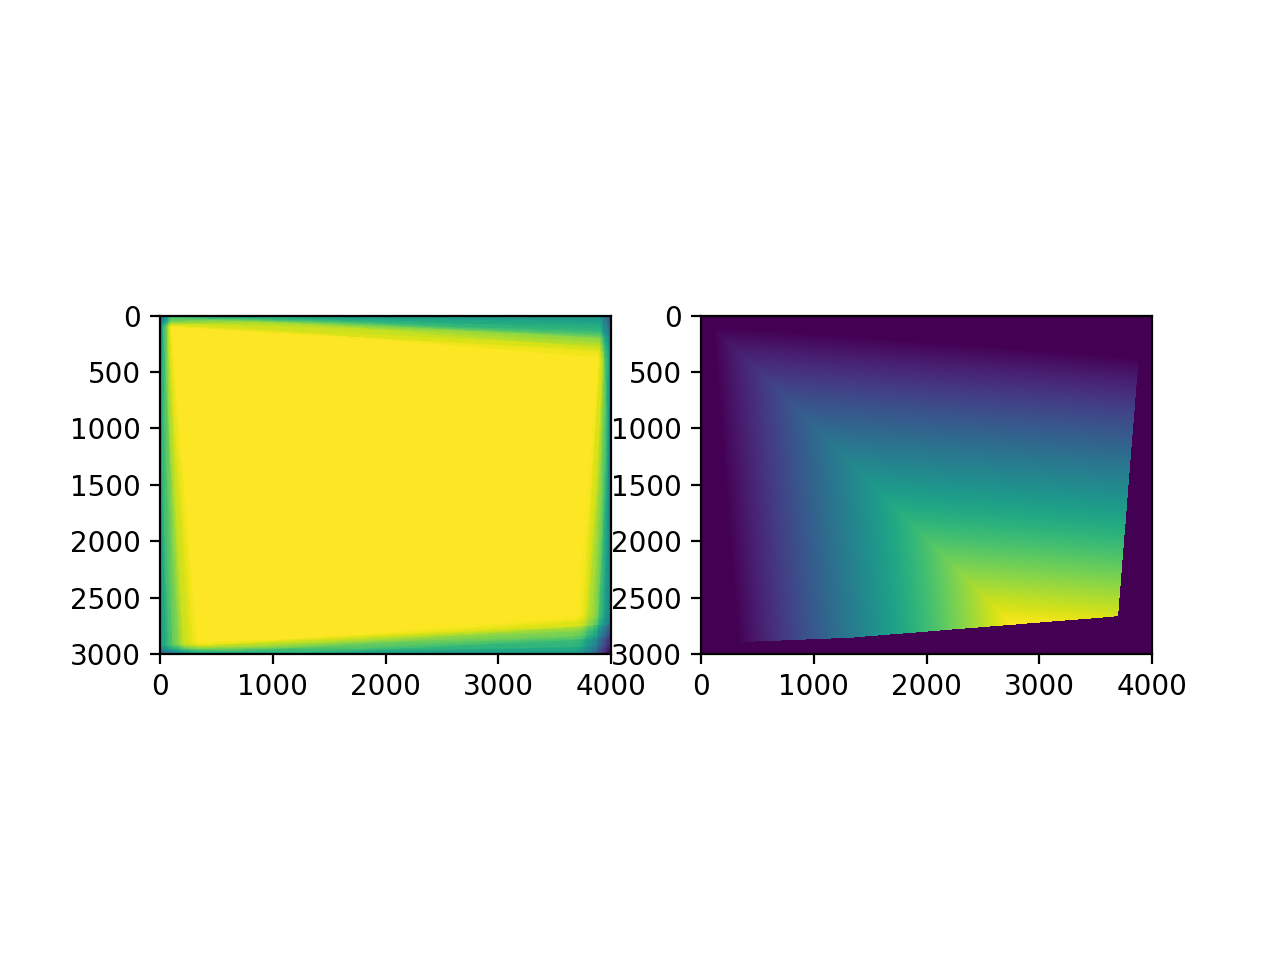

In [16]:
fig, ax = subplots(1,2)
ax[0].imshow(res)
ax[1].imshow(res==nimg)

In [19]:
%load_ext cython

In [41]:
%%cython -a
import numpy
import cython

@cython.boundscheck(False)
def cy_square_detection(data):
    cdef:
        int width, height, i, j
        int[:,::1] res, mask
    mask = numpy.ascontiguousarray(data, numpy.int32)
    res = numpy.zeros_like(mask)
    height = mask.shape[0]
    width = mask.shape[1]
    for i in range(height):
        res[i,0] = (mask[i,0] != 0)
    for j in range(width):
        res[0,j] = (mask[0,j] != 0)
    for i in range(1, height):
        for j in range(1, width):
            if mask[i,j] != 0:
                res[i,j] = 1 + min(res[i-1, j], res[i-1, j-1], res[i, j-1])
    return numpy.asarray(res)

#Some helper function for rectangles
cdef int getsize(int width, int height):
    "search for 16/9 images"
    return 16*width + 9*height

@cython.boundscheck(False)
def cy_rectangle_detection(data):
    cdef:
        int width, height, i, j, s, square, maxsquare, maxsize, rh, rw
        int[:,::1] sizes, squares, mask, widths, heights
        int[::1] height2width
    mask = numpy.ascontiguousarray(data, numpy.int32)
    squares = cy_square_detection(mask)
    height = mask.shape[0]
    width = mask.shape[1]    
    sizes = numpy.zeros_like(mask)
    widths = numpy.zeros_like(mask)
    heights = numpy.zeros_like(mask)
    maxsquare = 0

    for i in range(height):
        for j in range(width):
            square = squares[i, j]
            sizes[i, j] = getsize(square, square)
            if square > maxsquare:
                maxsquare = square
    
    height2width = numpy.empty(maxsquare+1, numpy.int32)    
    for i in range(height):
        for k in range(maxsquare+1):
            height2width[k] = 0
        for j in range(width):
            square = squares[i, j]
            if square > 0:
                maxsize = sizes[i, j]
                for rh in range(square, 0, -1):
                    rw = height2width[rh]
                    rw = max(rw+1, square)
                    height2width[rh] = rw
                    size = getsize(rw, rh)
                    if size > maxsize:
                        maxsize = size
                        widths[i,j]=rw
                        heights[i,j]=rh
                    sizes[i,j] = maxsize
                for k in range(square+1, maxsquare+1):
                    height2width[k] = 0
    return numpy.asarray(sizes), numpy.asarray(widths), numpy.asarray(heights)

CPU times: user 52 ms, sys: 16 ms, total: 68 ms
Wall time: 66.1 ms


<IPython.core.display.Javascript object>


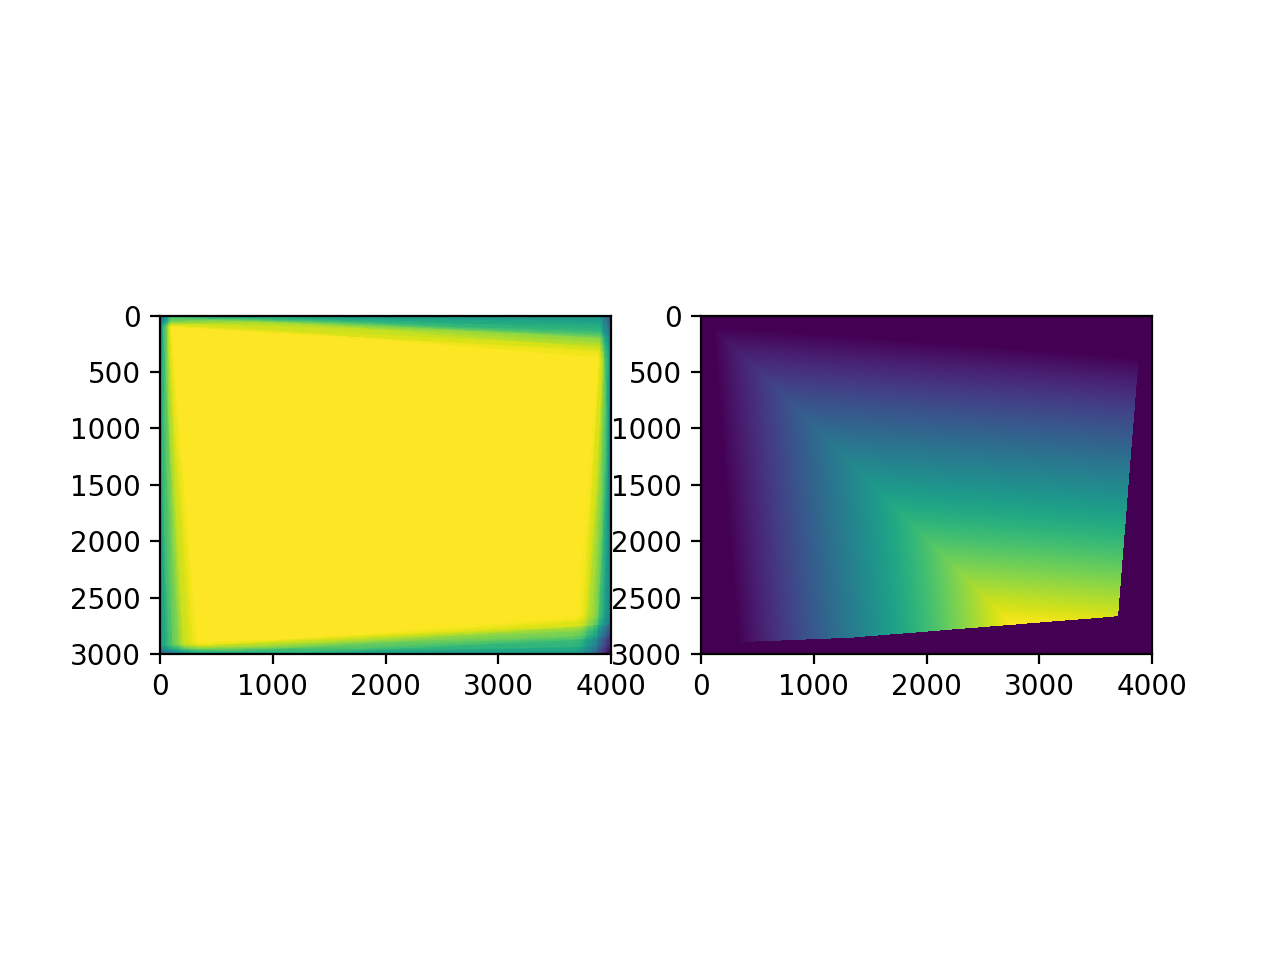

(array([2740, 2740]), array([2765, 2766]))


In [42]:
%time sq = cy_square_detection(res==nimg)
fig, ax = subplots(1,2)
ax[0].imshow(res)
ax[1].imshow(sq)
print(numpy.where(sq==sq.max()))

CPU times: user 21.7 s, sys: 64 ms, total: 21.8 s
Wall time: 21.8 s


<IPython.core.display.Javascript object>


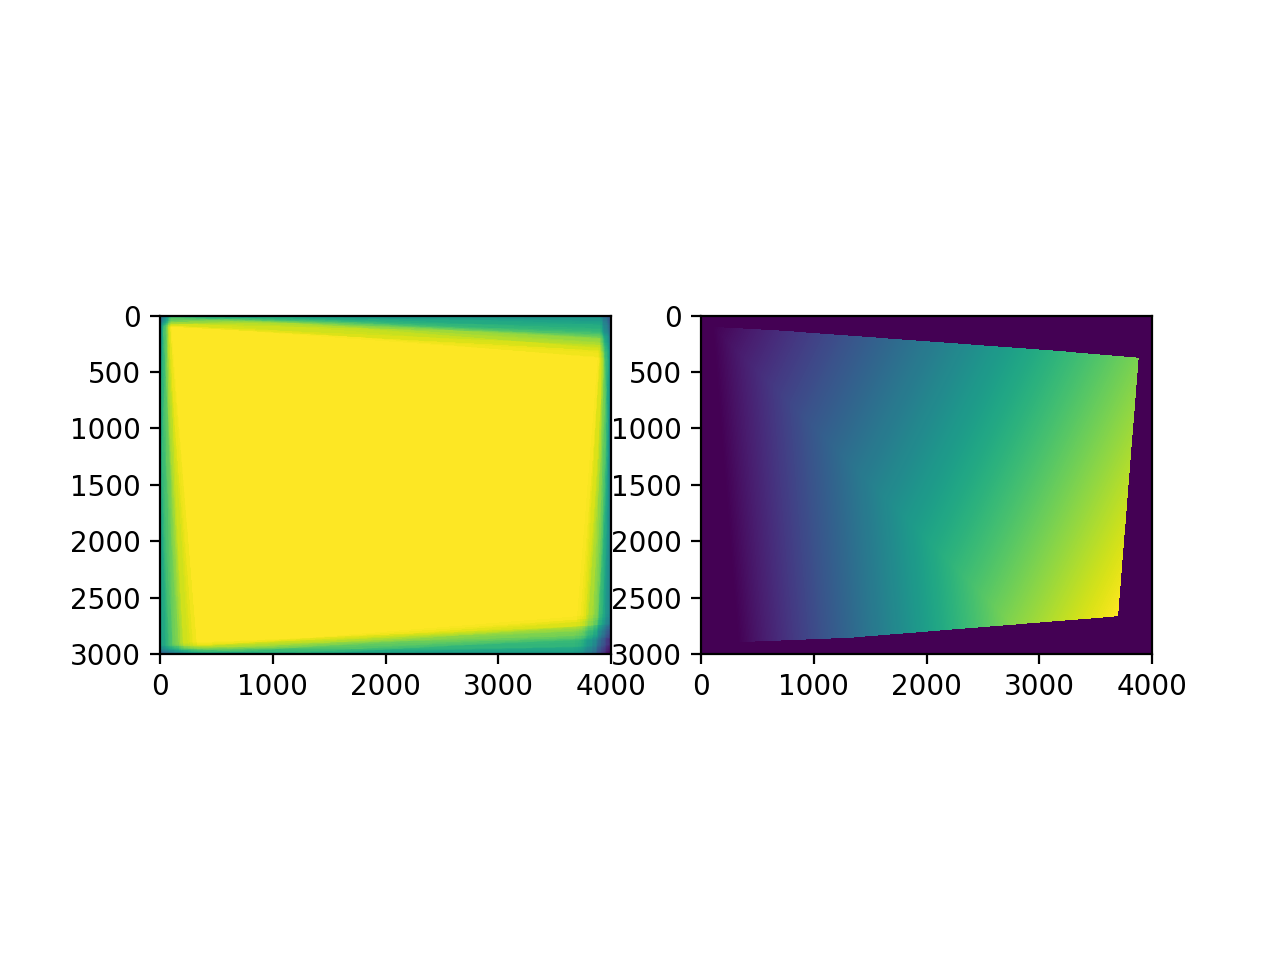

(array([2665]), array([3698]))


In [43]:
%time sizes, widths, heights = cy_rectangle_detection(res==nimg)
fig, ax = subplots(1,2)
ax[0].imshow(res)
ax[1].imshow(sizes)
print(numpy.where(sizes==sizes.max()))

In [32]:
from numba import jit

import numpy

@jit
def nb_square_detection(data):
    mask = numpy.ascontiguousarray(data, numpy.int32)
    res = numpy.zeros_like(mask)
    height = mask.shape[0]
    width = mask.shape[1]
    for i in range(height):
        res[i,0] = (mask[i,0] != 0)
    for j in range(width):
        res[0,j] = (mask[0,j] != 0)
    for i in range(1, height):
        for j in range(1, width):
            if mask[i,j] != 0:
                res[i,j] = 1 + min(res[i-1, j], res[i-1, j-1], res[i, j-1])
    return res

#Some helper function for rectangles
@jit
def getsize(width, height):
    "search for 16/9 images"
    return 16*width + 9*height

@jit
def nb_rectangle_detection(data):
    mask = numpy.ascontiguousarray(data, numpy.int32)
    squares = cy_square_detection(mask)
    height = mask.shape[0]
    width = mask.shape[1]    
    sizes = numpy.zeros_like(mask)
    widths = numpy.zeros_like(mask)
    heights = numpy.zeros_like(mask)
    maxsquare = 0

    for i in range(height):
        for j in range(width):
            square = squares[i, j]
            sizes[i, j] = getsize(square, square)
            if square > maxsquare:
                maxsquare = square
    
    height2width = numpy.zeros(maxsquare+1, numpy.int32)    
    for i in range(height):
        height2width[:] = 0
        for j in range(width):
            square = squares[i, j]
            if square > 0:
                maxsize = sizes[i, j]
                for rh in range(square, 0, -1):
                    rw = height2width[rh]
                    rw = max(rw+1, square)
                    height2width[rh] = rw
                    size = getsize(rw, rh)
                    if size > maxsize:
                        maxsize = size
                        widths[i,j]=rw
                        heights[i,j]=rh
                    sizes[i,j] = maxsize
                height2width[square+1:] = 0
    return sizes, widths, heights

CPU times: user 672 ms, sys: 32 ms, total: 704 ms
Wall time: 714 ms


<IPython.core.display.Javascript object>


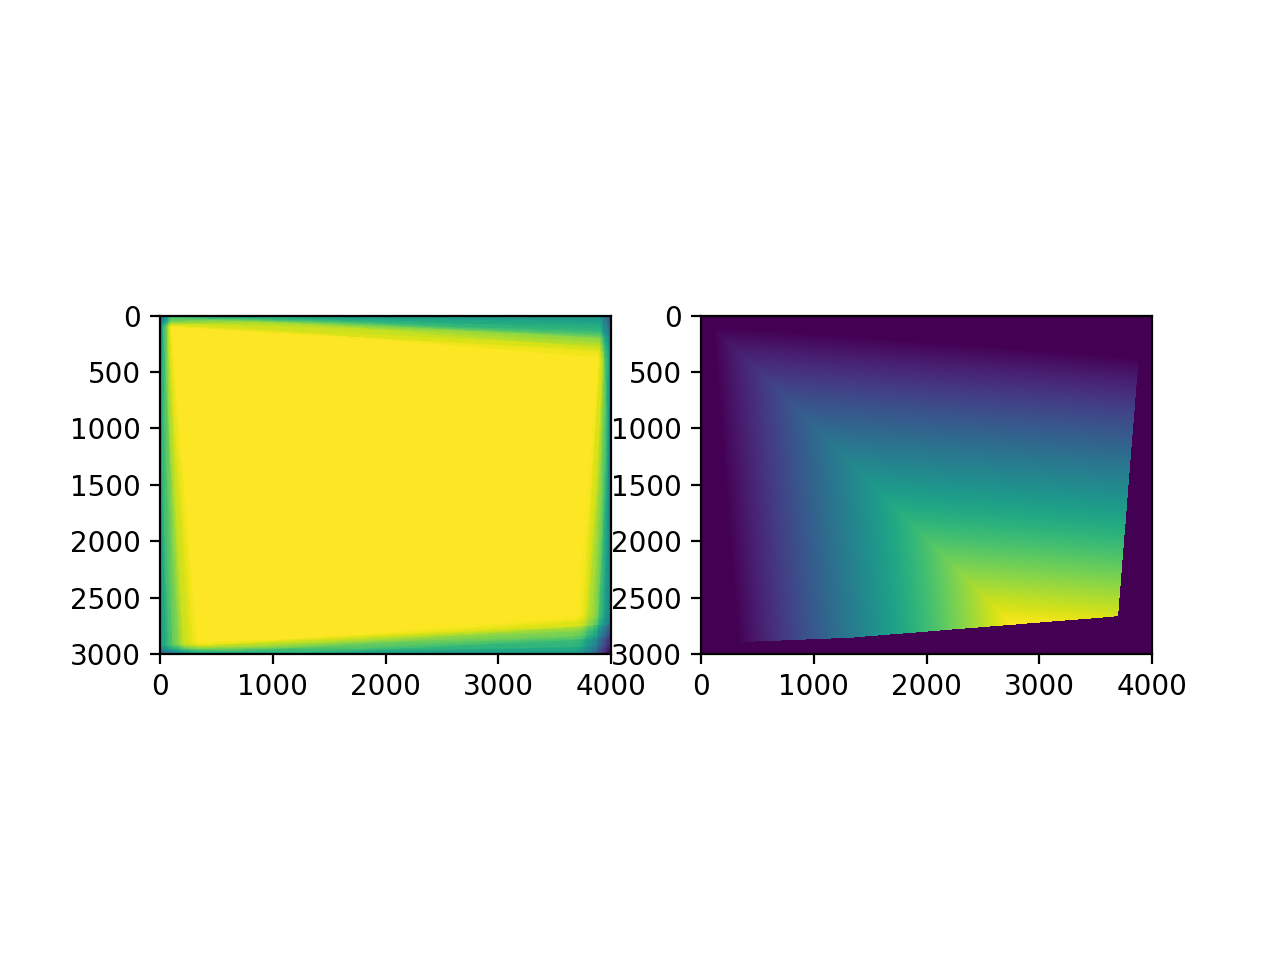

(array([2740, 2740]), array([2765, 2766]))


In [33]:
%time sq = nb_square_detection(res==nimg)
fig, ax = subplots(1,2)
ax[0].imshow(res)
ax[1].imshow(sq)
print(numpy.where(sq==sq.max()))

CPU times: user 12 s, sys: 52 ms, total: 12 s
Wall time: 12 s


<IPython.core.display.Javascript object>


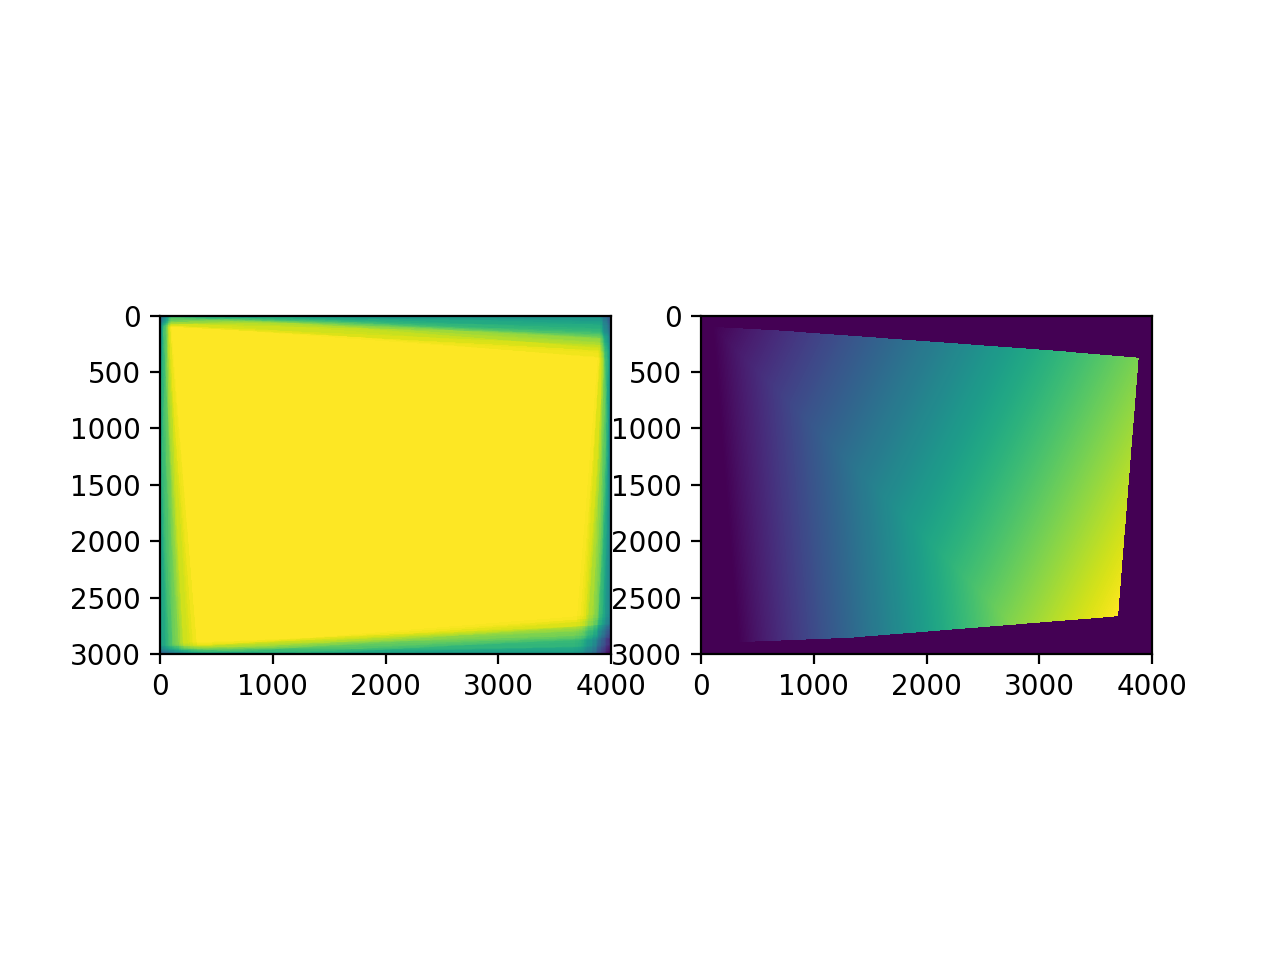

(array([2665]), array([3698]))


In [34]:
%time sizes, widths, heights = nb_rectangle_detection(res==nimg)
fig, ax = subplots(1,2)
ax[0].imshow(res)
ax[1].imshow(sizes)
print(numpy.where(sizes==sizes.max()))